# Sparse Dictionary Learning

This is the notebook where I construct the classes and functions used in sparse dictionary learning.

In [2]:
import numpy as np
import random
import cv2
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

### Helper Functions

In [3]:
def get_ith_patch(large_shape, patch_shape, i):
    # How many patches can we fit in this large array?
    patch_index_shape = np.array(large_shape) - np.array(patch_shape) + 1

    # What are the coordinates of the starting pixel of the ith patch?
    patch_index = np.unravel_index(i, patch_index_shape)

    # Get the indices for the pixels in the ith patch
    patch_indices = tuple(slice(start, start + size) for start, size in zip(patch_index, patch_shape))

    return patch_indices

def get_num_patches(large_shape, patch_shape):
    patch_index_shape = np.array(large_shape) - np.array(patch_shape) + 1
    return patch_index_shape.prod()


In [4]:
def load_image(path):
    img = cv2.imread(path)
    if (img[:,:,0] == img[:,:,1]).all():
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

## Random Sampler

It quickly became clear that I will have far more training data than I can possibly utilize in each iteration. So I will randomly sample the training data. This sampler will eventually be passed as an attribute of objects in another class.

In [5]:
class Sampler:

    def __init__(self, paths = [], num_samples = 300, patch_shape = np.array([8,8,3])):
        #self.seed = 1 # A random seed which will be updated after every use. It is there to ensure reproducibility
        self.paths = paths # A list of the paths where original images/signals are stored
        self.add_filter(None)
        self.num_samples = num_samples
        self.patch_shape = patch_shape

    def set_patch_shape(self, patch_shape):
        self.patch_shape = patch_shape

    def set_num_samples(self, num_samples):
        self.num_samples = num_samples

    def add_path(self, path):
        self.paths.append(path)

    def set_paths(self, paths):
        self.paths = paths

    def add_filter(self, filter, std = 10):

        if filter == None:
            foo = lambda x: x
            self.filter = foo

        elif filter == 'noise':

            def filter(sample):

                noise = np.zeros_like(sample)
                cv2.randn(noise, 0, std)
                sample = np.clip(sample + noise, 0, 255).astype(np.uint8)

                return sample
            self.filter = filter

    def sample(self, N = None):
        """
        A function which returns N samples. It returns a pair of matrices (Y_corrupted, Y_original).

        :param N:
        :param two_copies:

        :return:
        """
        def get_sample(img1, img2):
            """
            Helper function to get a single patch sample from an image.
            Args:
                img: np.array, representing an image
                add_noise: bool, whether to add Gaussian noise to the patch
            Returns:
                sample: np.array, of shape (d,), representing the sampled patch
            """

            # Get a random patch from the image
            patch = get_ith_patch(large_shape, self.patch_shape, random.randint(0, num_patches-1))

            return (img1[patch].flatten(), img2[patch].flatten())

        # Get the number of samples
        if N == None:
            N = self.num_samples

        # Get the product of the patch dimensions
        d = self.patch_shape.prod()

        # Initialize an array to hold the sampled patches
        Y = np.zeros([d, N], dtype=np.uint8)
        Y_orig = np.zeros([d, N], dtype=np.uint8)

        # Divide the number of samples requested evenly amongst each original full image
        j = 0
        r = N % len(self.paths)

        for i, path in enumerate(self.paths):

            # Read in the image, apply the filter, and if nessisary preserve the original copy
            img2 = load_image(path)
            img1 = self.filter(img2)

            # Get the shape of the image
            large_shape = img1.shape

            # Get the number of patches that can be extracted from the image
            num_patches = get_num_patches(large_shape, self.patch_shape)

            # Sample patches from the image
            for _ in range(N // len(self.paths)):
                (corrupted_sample, original_sample) = get_sample(img1, img2)
                Y[:, j] = corrupted_sample
                Y_orig[:, j] = original_sample
                j += 1

            # If there are any remaining samples, sample them from the current image
            if i < r:
                (corrupted_sample, original_sample) = get_sample(img1, img2)
                Y[:, j] = corrupted_sample
                Y_orig[:, j] = original_sample
                j += 1

        return (Y, Y_orig)

In [6]:
sam = Sampler()
sam.add_path('dinner.jpg')
sam.add_filter('noise', std = 1000)
sam.patch_shape = np.array([1000,1000,3])
(Y, Y_orig) = sam.sample(N=3)
Y

array([[ 65,  32, 173],
       [105,  35, 200],
       [114,  45, 194],
       ...,
       [151,  12, 150],
       [170,  53, 169],
       [181,  95, 182]], dtype=uint8)

In [7]:
#cv2.imshow('test', Y[:,0].reshape(sam.patch_shape))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

## Optimization Algorithms

Here I will define the Matching Pursuit (MP), Orthogonal Matching Pursuit (OMP), and k-means Singular Value Decomposition (k-SVD) algorithms. The k-SVD algorithm was first proposed for sparse dictionary learning in https://legacy.sites.fas.harvard.edu/~cs278/papers/ksvd.pdf. In the same algorithm I also use an unused atom replacement method examined in https://cs.unibuc.ro//~pirofti/papers/Irofti16_AtomReplacement.pdf.


In [8]:
def find_sparse_rep_MP(Y, D, L):
    """
    :param Y: This is a (d x N) matrix representing the N different d-dimensional given signals.
    :param D: This is a (d x K) matrix representing the dictionary of K different atoms, where the atoms are d-dimensional vectors. Each column vector must have already been normalized.
    :param L: This is an integer satisfying 0 < L <= K representing the maximum number of atoms which can be used in a sparse representation.

    Runs in O( N K L ) time.

    Note that we need N > K > d >= L

    :return: A, the (K x N) matrix of the N different K-dimensional sparse representations of the columns of Y.
    """

    (d, N) = Y.shape
    (d1, K) = D.shape
    assert d == d1, f"The dimensions dont add up: Y.shape = {Y.shape} and D.shape = {D.shape}" # Make sure the dimensions match up

    A = np.zeros((K, N)) # Get our Sparse Representation Matrix

    for j in range(N):  # Iterate over all of the N given signal vectors Y[:,j].

        alpha = np.zeros(K)  # Initialize the sparse representation vector (will be a column vector in A)
        r_vec = Y[:, j] - np.dot(D, alpha)  # Initialize the "residual" vector

        for i in range(L): # Repeat until we utilize L atoms, or no more are needed
            position_coeff_error = []

            for k in range(K): # Find the best atom, D[:,k]

                atom = D[:, k]

                # Project the residual vector r_vec down to the linear subspace defined by the atom
                coeff = np.inner(r_vec, atom)
                error = np.linalg.norm(r_vec - coeff * atom)
                position_coeff_error.append((k, coeff, error))

            position, coeff, error = min(position_coeff_error, key=lambda x: x[2]) # Find the atom whose linear subspace is closest to the residual vector r_vec

            if np.abs(coeff) < 1e-6: #If the coefficient is too small, we don't add it and instead end the iteration
                break

            else:
                alpha[position] += coeff # Update the sparse representation vector, alpha
                r_vec -= coeff * D[:, position] # Update the residual vector, r_vec

        A[:, j] = alpha # Insert the sparse representation vector alpha into the matrix A

    return A

In [9]:
def find_sparse_rep_OMP(Y, D, L):
    """
    Find the sparse representation of the given signals Y over the dictionary D using the Orthogonal Matching Pursuit
    algorithm.
    Runs in O( N K L^2 ) time.

    :param Y: A (d x N) matrix representing the N different d-dimensional given signals.
    :param D: A (d x K) matrix representing the dictionary of K different atoms, where the atoms are d-dimensional
    vectors. Each column vector must have already been normalized.
    :param L: An integer representing the maximum number of atoms which can be used in a sparse representation.

    Note that we need N > K > d >= L

    :return: A, a (K x N) matrix of the N different K-dimensional sparse representations of the columns of Y.
    """

    # Get the shapes of the input matrices
    (d, N) = Y.shape
    (d1, K) = D.shape

    # Ensure that the dimensions match up
    assert d == d1

    # Initialize the sparse representation matrix A
    A = np.zeros((K, N))

    # Iterate over all of the N given signal vectors Y[:,j].
    for j in range(N):

        # Initialize the set of indices for the selected atoms
        idx_set = set()

        # Repeat until we utilize L atoms, or no more are needed
        for i in range(L):

            # Find the remaining unused atoms
            remaining_atoms = set(range(K)).difference(idx_set)

            # Initialize a list to store the coefficients and errors for each candidate atom
            position_coeff_error = []

            # Iterate over the remaining unused atoms and calculate the projection error for each
            for k in remaining_atoms:
                # Create the subspace basis from the remaining unused atoms plus the current candidate atom
                subspace_basis = D[:, list(idx_set) + [k]]

                # Solve for the coefficients of the projection
                coeff = np.linalg.lstsq(subspace_basis, Y[:, j], rcond=None)[0]

                # Calculate the projected vector
                projected = np.dot(subspace_basis, coeff)

                # Calculate the error between the original signal and the projection
                error = np.linalg.norm(Y[:, j] - projected)

                # Store the position, coefficients, and error in the list
                position_coeff_error.append((k, coeff, error))

            # Select the candidate atom with the minimum projection error
            position, coeff, error = min(position_coeff_error, key=lambda x: x[2])

            # Add the selected atom to the set of indices for the selected atoms
            idx_set.add(position)

        # Create the final subspace basis from the selected atoms
        subspace_basis = D[:, list(idx_set)]

        # Solve for the coefficients of the sparse representation using the selected atoms
        coeff = np.linalg.lstsq(subspace_basis, Y[:, j], rcond=None)[0]

        # Initialize the sparse representation vector alpha
        alpha = np.zeros(K)

        # Insert the computed coefficients into the sparse representation vector alpha
        for position, index in enumerate(idx_set):
            alpha[index] = coeff[position]

        # Insert the sparse representation vector alpha into the matrix A
        A[:, j] = alpha

        # Return the matrix of sparse representations
    return A

In [10]:
def update_dictionary_kSVD(Y, D, A):
    """
    Update the dictionary using the k-SVD algorithm. This

    :param Y: This is the (d x N) matrix representing the N different d-dimensional given signals.
    :param D: This is the (d x K) matrix representing the dictionary of K different atoms, where the atoms are d-dimensional
    vectors. Each column vector must have already been normalized.
    :param A: This is the (K x N) matrix of the N different K-dimensional sparse representations of the columns of Y.

    :return: (D, A), where D is updated and optimized to the given  a (K x N) matrix of the N different K-dimensional sparse representations of the columns of Y.
    """

    # Get the shapes of the input matrices
    (d, N) = Y.shape
    (d1, K) = D.shape
    (K1, N1) = A.shape

    # Ensure that the dimensions match up
    assert d == d1
    assert K == K1
    assert N == N1

    # Iterate over every atom in the dictionary
    unused_atoms = []
    for k in range(K):
        # Find the signal vectors, Y[:,j], whose sparse representation, A[:,j], have a non-zero entry in the k^th position. That is, they use the k^th atom.
        non_zero_indices = np.nonzero(A[k, :])[0]

        if len(non_zero_indices) == 0:
            unused_atoms.append(k)

        else:
            # Get the k^th "error matrix"
            E = Y - np.dot(D, A) + np.outer(D[:, k], A[k, :])

            # Restrict the matrix to only those non-zero values. The resulting matrix should be KxL
            E = E[:, non_zero_indices]

            # Do the SVD (Singular Value Decomposition) step to the KxL matrix E
            U, S, V = np.linalg.svd(E, full_matrices=False)

            #print(f'For the k={k} atom, E={E}, and non_zero_indices = {non_zero_indices}')

            # Update the k^th atom, D[:, k], and the k^th coefficients in the sparse representation, A[k, :].
            # Note: The k-SVD algorithm also converges when run in parallel, only updating the matrix D at the end. However running the algorithm in series, updating the atoms and coefficients after each step, produces more robust results and typically requires more than four times as long to converge.
            D[:, k] = U[:, 0]
            A[k, non_zero_indices] = S[0] * V[0, :]

    # Replace the unused atoms with the worst represented sample vectors
    E = Y - np.dot(D, A)
    errors = []
    for j in range(N):
        errors.append((j, np.linalg.norm(E[:,j])))
    errors.sort(key = lambda x: -x[1])

    num_unused = len(unused_atoms)
    for i in range(num_unused):
        D[:, unused_atoms[i]] = Y[:, errors[i][0]]

    return (D, A)

## Dictionary Learners

This is the second class we will be defining. It will be doing the actual math part of the problem.

In [11]:
class DictionaryLearner:

    def __init__(self, L=5, K=100, sampler = None, algo = None, Dictionary = None):

        assert L<K, f"The total number of atoms, K={K}, must be greater than the maximum number of allowed atoms per sparse representation, L = {L}"

        self.L = L # The maximum number of atoms a sparse representation can use
        self.K = K # The size of the dictionary
        self.Dictionary = Dictionary # The initial guesses for the dictionary
        self.sampler = sampler
        self.select_algorithm(algo)
        self.errors = []

        self.update_dictionary_kSVD = update_dictionary_kSVD
        self.update_step()

    def set_sampler(self, sampler):
        self.sampler = sampler

    def set_initial_dictionary(self, D):
        self.Dictionary = D

    def select_algorithm(self, algo):
        if algo == 'MP':
            self.sparse_rep = find_sparse_rep_MP
        elif algo == 'OMP':
            self.sparse_rep = sparse_rep = find_sparse_rep_OMP

        else:
            self.sparse_rep = None

    def update_step(self, inner_loop = 1, use_orig = False):
        def update_dictionary(Y, Y_orig, D, A):
            for i in range(inner_loop):
                if use_orig:
                    (D, A) = self.update_dictionary_kSVD(Y_orig, D, A)
                else:
                    (D,A) = self.update_dictionary_kSVD(Y, D, A)
            return (D,A)
        self.update_dictionary = update_dictionary

In [12]:
def sparse_dictionary_learning(self, iters=10, output = True):
    """
    This algorithm finds a (d x K) matrix D (the dictionary) and a (K x N) matrix A (the sparse representation) which minimise the L2 distance between Y and D A, ie, minimise ||Y - D A ||, subject to the constraint that each column of A has at most L non-zero elements.

    :param Y: This is the (d x N) matrix representing the N different d-dimensional given signals.
    :param K: An integer representing the size of the dictionary.
    :param L: An integer representing the maximum number of "atoms", D[:, k], in the dictionary that each sparse representation vector, A[:, i], can use.

    Note: This algorithm is written under the assumption that: 0 < L < d < K < N

    :param D_initial: This is the initial guess for the (d x N) matrix D. If not None, the columns of this matrix must be unit length.
    :param algo: This is a string defining the sparse representation algorithm. Either algo = 'OMP' for Orhtogonal Matching Pursuit, or algo = 'MP' for Matching Pursuit.
    :param iters: The number of iterations this will run for
    :param with_errors: A boolean which determines if the output includes the list of the error values at each step of the iteration.
    :param samples: This tells us the number of random samples to take from the training data Y at each step

    :return: (D, A, errors)
        D: This is the (d x K) matrix representing the dictionary of K different atoms, where the atoms are d-dimensional
    vectors.
        A: This is the (K x N) matrix of the N different K-dimensional sparse representations of the columns of Y.
        errors: This is an optional output. It is the list of the error values at each step of the iteration.
    """

    # Make sure we have the proper stuff defined
    assert self.sparse_rep != None

    # Get the internal variables for ease
    K = self.K
    L = self.L
    sampler = self.sampler
    D = self.Dictionary
    sparse_rep = self.sparse_rep
    update_dictionary = self.update_dictionary

    # Get Initial Dictionary if there is none
    if D == None:
        (Y, _) = sampler.sample()
        N = len(Y[0, :])
        D = Y[:, random.sample(range(N), k=K)]
        D = D / np.linalg.norm(D, axis=0)

    for step in tqdm(range(iters)):

        # Get the batch of random samples
        (Y, Y_orig) = sampler.sample()

        # Find the Sparse Representations
        A = sparse_rep(Y, D, L)

        # Record the error
        error = np.linalg.norm(Y - np.dot(D, A))
        self.errors.append(error)

        # Update the Dictionary
        (D, A) = update_dictionary(Y, Y_orig, D, A)

    # Record the error one last time
    A = sparse_rep(Y, D, L)
    error = np.linalg.norm(Y - np.dot(D, A))
    self.errors.append(error)

    # Update Dictionary
    self.Dictionary = D

    if output:
        return D

DictionaryLearner.sparse_dictionary_learning = sparse_dictionary_learning

### Example

In [13]:
sam = Sampler(paths = ['dinner.jpg'])
learner = DictionaryLearner(L=5, K=200, sampler=sam, algo = 'OMP')
learner.sparse_dictionary_learning(iters = 1, output = True)

  0%|          | 0/1 [00:00<?, ?it/s]

array([[ 0.01505273, -0.05372083,  0.12266064, ..., -0.04066572,
        -0.06036148, -0.07526818],
       [ 0.03894526, -0.05492688,  0.10960457, ..., -0.04992455,
        -0.0655486 , -0.08287975],
       [ 0.05560684, -0.06948407,  0.13439041, ..., -0.07232947,
        -0.08536942, -0.10295235],
       ...,
       [ 0.07305914, -0.04757631,  0.02038069, ..., -0.05179757,
        -0.03276233, -0.06659294],
       [ 0.10061348, -0.05417472,  0.01539086, ..., -0.05615252,
        -0.03701733, -0.07153072],
       [ 0.13814567, -0.06757188,  0.05215227, ..., -0.06922708,
        -0.06017129, -0.08851196]])

In [14]:
def image_reconstruction(self, path):

    # Get internal stuff for ease of use
    D = self.Dictionary
    patch_shape = self.sampler.patch_shape
    patch_size = patch_shape[0]
    L = self.L

    img = load_image(path)
    large_shape = img.shape
    num_rows, num_cols = large_shape[:2]
    num_patches_rows = num_rows - patch_size + 1
    num_patches_cols = num_cols - patch_size + 1

    # Initialize the reconstructed image
    recon_img = np.zeros(img.shape, dtype=np.float32)
    count = np.zeros(img.shape, dtype=np.float32)

    # Initialize the progress bar
    pbar = tqdm(total=num_patches_rows*num_patches_cols)

    # Loop over all patches in the image
    for i in range(num_patches_rows):
        for j in range(num_patches_cols):
            # Extract the patch from the image
            patch = img[i:i+patch_size, j:j+patch_size, ...]

            # Compute the sparse coding of the patch
            sparse_patch_code = self.sparse_rep(patch.flatten().reshape(-1,1), D, L)
            recon_patch = np.dot(D, sparse_patch_code)
            recon_patch = recon_patch.reshape(patch_shape)

            # Add the reconstructed patch to the reconstructed image
            recon_img[i:i+patch_size, j:j+patch_size, ...] += recon_patch
            count[i:i+patch_size, j:j+patch_size, ...] += 1

            # Increment the counter variable and update the progress bar
            pbar.update(1)

    # Close the progress bar
    pbar.close()

    # Average the pixel values at each pixel to get the final reconstructed image
    recon_img /= count

    # Convert the reconstructed image to uint8
    recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)

    return recon_img

DictionaryLearner.image_reconstruction = image_reconstruction

### Image Size

After a few tests, it became clear that my computer (and patience) will not handle reconstructing large photos. So I will be compressing the photos down to 200x150 pixels. For now I will also be considering only black and white photos. Below we see the Original photo, along side the lower resolution version that I will be feeding into my algorithms

| Original (High Resolution)                                       | Compressed (Low Resolution)                                                 |
|------------------------------------------------------------------|-----------------------------------------------------------------------------|
| <img alt="Caption 1" height="300" src="dinner.jpg" width="400"/> | <img alt="Caption 2" height="300" src="small_gray_dinner.png" width="400"/> |

In [15]:
# Load the image
img = cv2.imread('dinner.jpg', cv2.IMREAD_COLOR)

# Resize the image to 400x300 pixels
img_resized = cv2.resize(img, (200, 150), interpolation=cv2.INTER_AREA)

# Convert the resized image to grayscale
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

print(img_gray.shape)

# Save the grayscale image as 'small_gray_dinner.png'
cv2.imwrite('small_gray_dinner.png', img_gray )

(150, 200)


True

In [16]:
#img = load_image('small_gray_dinner.png')
#print(img.shape)
#cv2.imshow('test',img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [17]:
learner.errors

[1260.6591954998876, 830.3741822678373]

In [18]:
sam = Sampler(paths = ['small_gray_dinner.png'], patch_shape=np.array([8,8]), num_samples=500 )
learner = DictionaryLearner(L=20, K=100, sampler=sam, algo = 'OMP')
learner.sparse_dictionary_learning(iters = 10, output = False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
path = 'small_gray_dinner.png'
reconI10L20_img = learner.image_reconstruction(path)

  0%|          | 0/27599 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
cv2.imwrite('reconI10L20_small_gray_dinner.png', reconI10L20_img)

NameError: name 'reconI10L20_img' is not defined

In [21]:

cv2.imshow('Reconstruction0', recon0_img)
cv2.moveWindow("Reconstruction0", 0, 0)

cv2.imshow('Reconstruction1', recon_img)
cv2.moveWindow("Reconstruction1", recon0_img.shape[1], 0)

cv2.imshow('Reconstruction10K500', recon10K500_img)
cv2.moveWindow("Reconstruction10K500", recon_img.shape[1] + recon0_img.shape[1], 0)

cv2.imshow('ReconstructionI10L20', reconI10L20_img)
cv2.moveWindow("ReconstructionI10L20", recon_img.shape[1] + recon0_img.shape[1] + recon10K500_img.shape[1], 0)

cv2.imshow('Original', img)
cv2.moveWindow("Original", recon_img.shape[1] + recon0_img.shape[1] + recon10K500_img.shape[1] + reconI10L20_img.shape[1], 0)

cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'recon0_img' is not defined

In [22]:
img_orig = load_image('small_gray_dinner.png')
img_recon1 = load_image('recon_small_gray_dinner.png')
img_recon10 = load_image('recon10_small_gray_dinner.png')
recon10K500_img = load_image('recon10K500_small_gray_dinner.png')
recon0_img = load_image('recon0_small_gray_dinner.png')

num_pixels = np.array(img_orig.shape).prod()

error0 = np.linalg.norm(img_orig-recon0_img)/np.sqrt(num_pixels)
error1 = np.linalg.norm(img_orig-img_recon1)/np.sqrt(num_pixels)
error10 = np.linalg.norm(img_orig - img_recon10)/np.sqrt(num_pixels)
error10K500 = np.linalg.norm(img_orig - recon10K500_img)/np.sqrt(num_pixels)
errorI10L20 = np.linalg.norm(img_orig - reconI10L20_img)/np.sqrt(num_pixels)

print(f'Error after 0 iterations: {error0}')
print(f'Error after 1 iterations: {error1}')
print(f'Error after 10 iterations: {error10}')
print(f'Error after 10 iterations (with batch size of N=500): {error10K500}')
print(f'Error after 10 iterations (with batch size of N=500, and L=20): {errorI10L20}')


NameError: name 'reconI10L20_img' is not defined

In [23]:
#D10 = learner.Dictionary
#D10K500 = learner.Dictionary
#D0 = learner.Dictionary
#DI10L20 = learner.Dictionary

## Comparison

Here are the results of a few tests. Note that these tests are purely to get an idea of what the algorithms are capable of. A full battery of tests will be preformed in another notebook.

ALl tests are run by compressing and reconstructing a single image. The algorithm is trained and tested on the same image.

I = number of iterations of the dictionary learning algorithm (k-SVD)
K = number of atoms
L = max number of atoms allowed in a sparse representation
N = number of random samples provided (batch size) at each step

### Dictionary Learning Iterations
How many iterations (I = num_iters) of the dictionary learning (k-SVD) algorithm do we need to run? Note that at I=0 our atoms are initialized as random patches of our image.

| I = 0 | I = 1 | I = 10 | Original |
|-------|-------|--------|----------|
| <img alt="Recon 0" height="300" src="recon0_small_gray_dinner.png" width="400"/> | <img alt="Recon 1" height="300" src="recon_small_gray_dinner.png" width="400"/> | <img alt="Recon 10" height="300" src="recon10_small_gray_dinner.png" width="400"/> | <img alt="Original" height="300" src="small_gray_dinner.png" width="400"/> |

Notice how there isn't much of a difference.

### Batch Size
How many samples should I provide? Both experiments were preformed with I=10

 N=100  | N=500                                          | Original |
-------|------------------------------------------------|----------|
| <img alt="Recon 1" height="300" src="recon10_small_gray_dinner.png" width="400"/> | <img alt="Recon 10" height="300" src="recon10K500_small_gray_dinner.png" width="400"/> | <img alt="Original" height="300" src="small_gray_dinner.png" width="400"/> |

Again, not much of a change.

### Atoms in the Sparse Representation
How many atoms should I use in the sparse representation?

 L=5 | L=20                                                                                   | Original |
-------|----------------------------------------------------------------------------------------|----------|
| <img alt="Recon 1" height="300" src="recon10K500_small_gray_dinner.png" width="400"/> | <img alt="Recon 10" height="300" src="reconI10L20_small_gray_dinner.png" width="400"/> | <img alt="Original" height="300" src="small_gray_dinner.png" width="400"/> |

We finally have a dramatic improvement. It seems that of all the parameters, L is by far the most important.

## Stochastic Partial Image Reconstruction (SPIR)

During the previous experiments I learned that image reconstruction is extremely slow since I need to do sparse coding for every 8x8 patch. This led to the idea of using a stochastic method to only randomly select patches. Surely with enough patches I should be able to reconstruct most of the image. And more importantly, I will be able to get an accurate estimate of the error without reconstructing the whole thing.

In [24]:
def SPIR_plot(self, path):

    mincounts = [1,2,3,4,5,10,20,40,60]
    df = pd.DataFrame(columns=mincounts)

    # Get internal stuff for ease of use
    D = self.Dictionary
    patch_shape = self.sampler.patch_shape
    patch_size = patch_shape[0]
    L = self.L

    img = load_image(path)
    large_shape = img.shape
    num_rows, num_cols = large_shape[:2]
    num_patches_rows = num_rows - patch_size + 1
    num_patches_cols = num_cols - patch_size + 1
    num_patches = num_patches_cols*num_patches_rows

    #print(f'The image shape is {img.shape} with ')

    # Initialize the reconstructed image
    recon_img = np.zeros(img.shape, dtype=np.float32)
    count = np.zeros(img.shape, dtype=np.float32)

    # Initialize the progress bar
    total = int(1.5*num_patches)
    pbar = tqdm(total=total)

    for i in range(total):

        index = random.randint(0,num_patches-1)
        row_idx, col_idx  = (index // num_patches_cols, index % num_patches_cols)

        # Extract the patch from the image
        patch = img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...]

        # Compute the sparse coding of the patch
        #print(f'The patch shape is patch.shape = {patch.shape}')
        #print(f'The patch is patch = {patch}')
        #print(f'It ought to be [{row_idx}:{row_idx+patch_size}, {col_idx}:{col_idx+patch_size}]')
        sparse_patch_code = self.sparse_rep(patch.flatten().reshape(-1,1), D, L)
        recon_patch = np.dot(D, sparse_patch_code)
        recon_patch = recon_patch.reshape(patch_shape)

        # Add the reconstructed patch to the reconstructed image
        recon_img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += recon_patch
        count[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += 1

        # Increment the counter variable and update the progress bar
        pbar.update(1)

        if i%100 == 0:

            temp_recon = recon_img.copy().flatten()
            temp_count = count.copy().flatten()
            temp_img = img.copy().flatten()

            for m in mincounts:
                temp_indices = np.where(temp_count>m)[0]
                M = len(temp_indices)
                error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)

                df.loc[i, m] = error

    return df

DictionaryLearner.SPIR_plot = SPIR_plot

In [25]:
sam = Sampler(paths = ['small_gray_dinner.png'], patch_shape=np.array([8,8]), num_samples=300 )
learner = DictionaryLearner(L=5, K=100, sampler=sam, algo = 'OMP')
learner.sparse_dictionary_learning(iters = 10, output = False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
df = learner.SPIR_plot('small_gray_dinner.png')

  0%|          | 0/41398 [00:00<?, ?it/s]

C:\Users\raino\AppData\Local\Temp\ipykernel_10296\4270411027.py:61: RuntimeWarning: invalid value encountered in true_divide
  error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)
C:\Users\raino\AppData\Local\Temp\ipykernel_10296\4270411027.py:61: RuntimeWarning: invalid value encountered in true_divide
  error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)
C:\Users\raino\AppData\Local\Temp\ipykernel_10296\4270411027.py:61: RuntimeWarning: invalid value encountered in true_divide
  error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)
C:\Users\raino\AppData\Local\Temp\ipykernel_10296\4270411027.py:61: RuntimeWarning: invalid value encountered in true_divide
  error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)
C:\Users\raino\AppData\Local\Temp\ipyker

In [27]:
df

,1,2,3,4,5,10,20,40,60
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,8.628573,12.530076,2.854216,NaN,NaN,NaN,NaN,NaN,NaN
200,8.60531,7.717501,15.624603,3.854513,NaN,NaN,NaN,NaN,NaN
300,8.80214,8.302466,8.569246,5.964399,6.386593,NaN,NaN,NaN,NaN
400,9.110376,8.175524,8.056928,6.035319,4.315515,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
40900,7.14713,7.143225,7.138993,7.138828,7.138753,7.155955,7.21588,7.3377,7.466298
41000,7.146955,7.14305,7.138819,7.138653,7.138578,7.155676,7.215722,7.337456,7.465532
41100,7.146308,7.142402,7.13817,7.138003,7.13864,7.154821,7.21485,7.336267,7.463967
41200,7.145518,7.141612,7.137379,7.137212,7.137848,7.154026,7.214218,7.335539,7.46195


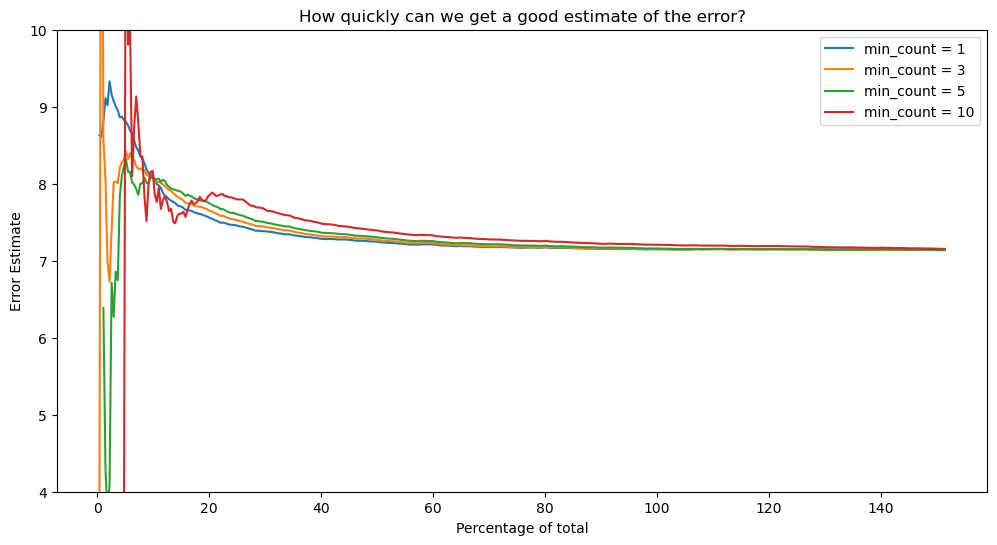

In [28]:


# define total as the maximum value of the index
total = (200-8)*(150-8)

# set the x-axis values as a percentage
x_values = df.index.values / total * 100

# increase width of plot
plt.figure(figsize=(12, 6))

# plot each column as a line plot with labels
for column in [1, 3, 5, 10]:
    y_values = df[column].values
    label = "min_count = " + str(column)
    plt.plot(x_values, y_values, label=label)

# set y-axis limits to between 4 and 10
plt.ylim(4, 10)

# add a legend and axis labels
plt.legend()
plt.xlabel('Percentage of total')
plt.ylabel('Error Estimate')

# set the title of the plot
plt.title("How quickly can we get a good estimate of the error?")

plt.savefig('SPIR_graph.jpg')

# show the plot
plt.show()


### Results

We conclude that using only about 20% of the patches with a min_count = 1 should be sufficient to get an accurate estimate of the error.

In [29]:
def SPIR(self, path, percent = .2, min_count = 1):

    # Get internal stuff for ease of use
    D = self.Dictionary
    patch_shape = self.sampler.patch_shape
    patch_size = patch_shape[0]
    L = self.L

    img = load_image(path)
    large_shape = img.shape
    num_rows, num_cols = large_shape[:2]
    num_patches_rows = num_rows - patch_size + 1
    num_patches_cols = num_cols - patch_size + 1
    num_patches = num_patches_cols*num_patches_rows

    #print(f'The image shape is {img.shape} with ')

    # Initialize the reconstructed image
    recon_img = np.zeros(img.shape, dtype=np.float32)
    count = np.zeros(img.shape, dtype=np.float32)

    # Initialize the progress bar
    total = int(percent*num_patches)
    pbar = tqdm(total=total)

    for i in range(total):

        index = random.randint(0,num_patches-1)
        row_idx, col_idx  = (index // num_patches_cols, index % num_patches_cols)

        # Extract the patch from the image
        patch = img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...]

        # Compute the sparse coding of the patch
        sparse_patch_code = self.sparse_rep(patch.flatten().reshape(-1,1), D, L)
        recon_patch = np.dot(D, sparse_patch_code)
        recon_patch = recon_patch.reshape(patch_shape)

        # Add the reconstructed patch to the reconstructed image
        recon_img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += recon_patch
        count[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += 1

        # Increment the counter variable and update the progress bar
        pbar.update(1)


    temp_recon = recon_img.copy().flatten()
    temp_count = count.copy().flatten()
    temp_img = img.copy().flatten()
    temp_indices = np.where(temp_count>min_count)[0]
    M = len(temp_indices)
    error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)

    recon_img = recon_img // count
    recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)

    return (recon_img, error)

DictionaryLearner.SPIR = SPIR

In [30]:
sam = Sampler(paths = ['small_gray_dinner.png'], patch_shape=np.array([8,8]), num_samples=300 )
learner = DictionaryLearner(L=5, K=100, sampler=sam, algo = 'OMP')
learner.sparse_dictionary_learning(iters = 10, output = False)
recon, error = learner.SPIR('small_gray_dinner.png')
print(f'The estimated error = {error}')

cv2.imwrite('precon10_small_gray_dinner.png', recon)
#cv2.imshow('SPIR', recon)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5519 [00:00<?, ?it/s]

The estimated error = 7.671155165195015


C:\Users\raino\AppData\Local\Temp\ipykernel_10296\1350825028.py:54: RuntimeWarning: invalid value encountered in floor_divide
  recon_img = recon_img // count


True

### Comparison

Below we compare the full reconstruction to the partial reconstruction of this image. The parameters were otherwise the same (N=300, I=10, K=100, L=5)

 Full Reconstruction  | Partial Reconstruction                                                              |
-------|-------------------------------------------------------------------------------------|
| <img alt="Recon 1" height="300" src="recon10_small_gray_dinner.png" width="400"/> | <img alt="Recon 10" height="300" src="precon10_small_gray_dinner.png" width="400"/> |


Note that when we do our error estimation, we ignore the missing pixels.

Keep in mind the later method is takes 20% the runtime and only slightly overestimates the error.


In [31]:
recon

array([[104,  78,  37, ...,   0,   0,   0],
       [116, 100,  43, ...,   0,   0,   0],
       [121, 118,  71, ...,   0,   0,   0],
       ...,
       [  0,  34,  33, ...,   0,   0,   0],
       [  0,   0,  33, ...,   0,   0,   0],
       [  0,   0,  32, ...,   0,   0,   0]], dtype=uint8)

<img alt="text 1" height="300" src="small_gray_dinner.png" width="400"/>
<img alt="text 2" height="300" src="small_gray_dinner.png" width="400"/>

| Title 1 | Title 2 |
|---------|---------|
| <img alt="Caption 1" height="300" src="small_gray_dinner.png" width="400"/> | <img alt="Caption 2" height="300" src="small_gray_dinner.png" width="400"/> |


In [32]:
import numpy as np

# Example input arrays
a = np.array([1, 2, 3])
b = np.array([2, 0, 1])

# Example 1: Convert output to float using astype()
c = np.true_divide(a, b).astype(float)
print(c)  # output: [0.5 inf 3.0]

# Example 2: Use floor division operator //
d = a // b
print(d)  # output: [0 -9223372036854775808 3]


[0.5 inf 3. ]
[0 0 3]


C:\Users\raino\AppData\Local\Temp\ipykernel_10296\3597313617.py:8: RuntimeWarning: divide by zero encountered in true_divide
  c = np.true_divide(a, b).astype(float)
C:\Users\raino\AppData\Local\Temp\ipykernel_10296\3597313617.py:12: RuntimeWarning: divide by zero encountered in floor_divide
  d = a // b


In [33]:
np.array([29])//np.array([0])

C:\Users\raino\AppData\Local\Temp\ipykernel_10296\828835782.py:1: RuntimeWarning: divide by zero encountered in floor_divide
  np.array([29])//np.array([0])


array([0], dtype=int32)

In [ ]:
sam = Sampler(paths = ['small_gray_dinner.png'], patch_shape=np.array([8,8]), num_samples=300 )
learner = DictionaryLearner(L=20, K=100, sampler=sam, algo = 'OMP')
learner.sparse_dictionary_learning(iters = 10, output = False)
error = learner.SPIR('small_gray_dinner.png')
print(f'The estimated error = {error}')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
specific_indicies = np.extract(a > 0, a)
b = a.copy()
b.flatten()[specific_indicies]

In [ ]:
def SPIRplus_plot(self, path):

    mincounts = [1,2,4,8,16,32]
    df = pd.DataFrame(columns=mincounts)

    # Get internal stuff for ease of use
    D = self.Dictionary
    patch_shape = self.sampler.patch_shape
    patch_size = patch_shape[0]
    L = self.L

    img = load_image(path)
    large_shape = img.shape
    num_rows, num_cols = large_shape[:2]
    num_patches_rows = num_rows - patch_size + 1
    num_patches_cols = num_cols - patch_size + 1
    num_patches = num_patches_cols*num_patches_rows

    #print(f'The image shape is {img.shape} with ')

    # Initialize the reconstructed image
    recon_img = np.zeros(img.shape, dtype=np.float32)
    count = np.zeros(img.shape, dtype=np.float32)

    # Initialize the progress bar
    total = int(.2*num_patches + (num_patches_rows//patch_size)*(num_patches_cols // patch_size))
    pbar = tqdm(total=total)

    # Get patches that barely cover the image
    for row_idx in range(num_patches_rows//patch_size):
        for col_idx in range(num_patches_cols // patch_size):

            # Extract the patch from the image
            patch = img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...]

            # Compute the sparse coding of the patch
            sparse_patch_code = self.sparse_rep(patch.flatten().reshape(-1,1), D, L)
            recon_patch = np.dot(D, sparse_patch_code)
            recon_patch = recon_patch.reshape(patch_shape)

            # Add the reconstructed patch to the reconstructed image
            recon_img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += recon_patch
            count[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += 1

            # Increment the counter variable and update the progress bar
            pbar.update(1)

    predone = (num_patches_rows//patch_size)*(num_patches_cols // patch_size)

    for i in range(int(.2*num_patches)):

        index = random.randint(0,num_patches-1)
        row_idx, col_idx  = (index // num_patches_cols, index % num_patches_cols)

        # Extract the patch from the image
        patch = img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...]

        # Compute the sparse coding of the patch
        sparse_patch_code = self.sparse_rep(patch.flatten().reshape(-1,1), D, L)
        recon_patch = np.dot(D, sparse_patch_code)
        recon_patch = recon_patch.reshape(patch_shape)

        # Add the reconstructed patch to the reconstructed image
        recon_img[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += recon_patch
        count[row_idx:row_idx+patch_size, col_idx:col_idx+patch_size, ...] += 1

        # Increment the counter variable and update the progress bar
        pbar.update(1)

        if i%100 == 0:

            temp_recon = recon_img.copy().flatten()
            temp_count = count.copy().flatten()
            temp_img = img.copy().flatten()

            for m in mincounts:
                temp_indices = np.where(temp_count>m)[0]
                M = len(temp_indices)
                error = np.linalg.norm(temp_img[temp_indices] -  (temp_recon[temp_indices]/temp_count[temp_indices]))/np.sqrt(M)

                df.loc[i + predone, m] = error

    return df

DictionaryLearner.SPIRplus_plot = SPIRplus_plot

In [ ]:
sam = Sampler(paths = ['small_gray_dinner.png'], patch_shape=np.array([8,8]), num_samples=300 )
learner = DictionaryLearner(L=5, K=100, sampler=sam, algo = 'OMP')
learner.sparse_dictionary_learning(iters = 10, output = False)
df2 = learner.SPIRplus_plot('small_gray_dinner.png')

In [ ]:
# define total as the maximum value of the index
total = (200-8)*(150-8)

# set the x-axis values as a percentage
x_values = df2.index.values / total * 100

# increase width of plot
plt.figure(figsize=(12, 6))

# plot each column as a line plot with labels
for column in df2.columns:
    y_values = df2[column].values
    label = "min_count = " + str(column)
    plt.plot(x_values, y_values, label=label)

# set y-axis limits to between 4 and 10
plt.ylim(4, 10)

# add a legend and axis labels
plt.legend()
plt.xlabel('Percentage of total')
plt.ylabel('Error Estimate')

# set the title of the plot
plt.title("How quickly can we get a good estimate of the error?")

# show the plot
plt.show()


In [ ]:
def reconstruct_image(D, img, patch_size, alpha):
    # Compute the number of patches in the image
    num_rows, num_cols = img.shape[:2]
    num_patches_rows = num_rows - patch_size + 1
    num_patches_cols = num_cols - patch_size + 1

    # Initialize the reconstructed image
    recon_img = np.zeros(img.shape, dtype=np.float32)
    count = np.zeros(img.shape, dtype=np.float32)

    # Loop over all patches in the image
    for i in tqdm(range(num_patches_rows)):
        for j in range(num_patches_cols):
            # Extract the patch from the image
            patch = img[i:i+patch_size, j:j+patch_size, :]

            # Compute the sparse coding of the patch
            code = find_sparse_rep_OMP(Y, D, L)
            sparse_code(D, patch, alpha)

        # Reconstruct the patch using the dictionary
        recon_patch = np.dot(D, code)
        recon_patch = np.reshape(recon_patch, (patch_size, patch_size, 3))

        # Add the reconstructed patch to the reconstructed image
        recon_img[i:i+patch_size, j:j+patch_size, :] += recon_patch
        count[i:i+patch_size, j:j+patch_size, :] += 1

# Average the pixel values at each pixel to get the final reconstructed image
recon_img /= count

# Convert the reconstructed image to uint8
recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)

return recon_img


In [ ]:
import numpy as np

np.array([1,2,3]).prod()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import random
random.randint(0,10)

In [ ]:
2

In [ ]:
np.random.normal(0, 0.1, np.array([8,8]))

In [ ]:
img